In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import glob

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

import discovery.likelihood_refactored as dsl

In [2]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]
psr = allpsrs[0]

In [3]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement_simple(psr)])
m2 = dsl.PulsarLikelihood([psr.residuals,
                          ds.makenoise_measurement_simple(psr)])

In [4]:
m.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

In [5]:
m2.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

In [6]:
test_pars = ds.sample_uniform(m.logL.params)

In [7]:
%%timeit
jax.block_until_ready(m.logL(test_pars))


114 μs ± 4.78 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

110 μs ± 1.18 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
jlogl_m(test_pars) == jlogl_m(test_pars)

Array(True, dtype=bool)

In [10]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

38.5 μs ± 502 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

39.1 μs ± 222 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr),
                         ds.makegp_timing(psr, svd=True),
                        #  ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])
m2 = dsl.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr),
                         ds.makegp_timing(psr, svd=True),
                        #  ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])

In [13]:
test_pars = ds.sample_uniform(m.logL.params)

In [14]:
%%timeit
jax.block_until_ready(m.logL(test_pars))

31.9 ms ± 271 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

44.6 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

41.5 ms ± 631 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
print(jlogl_m(test_pars))
print(jlogl_m2(test_pars))

89157.92917669509
89157.92917669508


In [18]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

22.2 ms ± 333 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

22.1 ms ± 332 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%prun
for ii in range(100):
    jax.block_until_ready(m.logL(test_pars))

         641339 function calls (641337 primitive calls) in 3.806 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    1.401    0.014    1.401    0.014 api.py:2951(try_to_block)
     3800    1.285    0.000    1.296    0.000 ufunc_api.py:176(__call__)
     5300    0.485    0.000    1.782    0.000 array_methods.py:581(deferring_binary_op)
     2900    0.279    0.000    0.286    0.000 dispatch.py:84(apply_primitive)
      800    0.065    0.000    0.074    0.000 matrix.py:18(<lambda>)
     1500    0.022    0.000    0.080    0.000 indexing.py:785(index_to_gather)
    14900    0.015    0.000    0.026    0.000 core.py:1684(get_aval)
   132307    0.013    0.000    0.015    0.000 {built-in method builtins.isinstance}
     1200    0.012    0.000    0.014    0.000 reductions.py:237(sum)
      2/1    0.007    0.003    3.597    3.597 <string>:1(<module>)
     1500    0.006    0.000    0.007    0.000 _function_base_impl.py:1391(di

In [21]:
%%prun
for ii in range(100):
    jax.block_until_ready(m2.logL(test_pars))

         1309368 function calls (1308967 primitive calls) in 4.640 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    1.642    0.016    1.642    0.016 api.py:2951(try_to_block)
     5700    1.451    0.000    1.468    0.000 ufunc_api.py:176(__call__)
     5400    0.481    0.000    0.496    0.000 dispatch.py:84(apply_primitive)
     8000    0.443    0.000    1.914    0.000 array_methods.py:581(deferring_binary_op)
     3400    0.051    0.000    0.185    0.000 indexing.py:785(index_to_gather)
    32600    0.036    0.000    0.060    0.000 core.py:1684(get_aval)
   267707    0.028    0.000    0.033    0.000 {built-in method builtins.isinstance}
     2300    0.022    0.000    0.026    0.000 reductions.py:237(sum)
     1400    0.022    0.000    0.037    0.000 matrix.py:18(<lambda>)
     3400    0.014    0.000    0.016    0.000 _function_base_impl.py:1391(diff)
      900    0.013    0.000    1.754    0.002 signals.py:88(g

In [22]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])
m2 = dsl.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')
                         ])

In [23]:
test_pars = ds.sample_uniform(m.logL.params)

In [24]:
m2.logL(test_pars)

Array(90998.49655446, dtype=float64)

In [25]:
%%timeit
jax.block_until_ready(m.logL(test_pars))

187 μs ± 6.26 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
%%timeit
jax.block_until_ready(m2.logL(test_pars))

178 μs ± 2.71 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
jlogl_m = jax.jit(m.logL)
jlogl_m2 = jax.jit(m2.logL)
jlogl_m(test_pars)==jlogl_m2(test_pars)

Array(True, dtype=bool)

In [28]:
%%timeit
jax.block_until_ready(jlogl_m(test_pars))

39.1 μs ± 224 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%%timeit
jax.block_until_ready(jlogl_m2(test_pars))

39.3 μs ± 977 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m.logL(test_pars))

         3130169 function calls (3130167 primitive calls) in 1.897 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.521    0.000    0.694    0.000 ufunc_api.py:176(__call__)
    20000    0.211    0.000    0.389    0.000 matrix.py:18(<lambda>)
    20000    0.161    0.000    0.178    0.000 reductions.py:237(sum)
   130000    0.138    0.000    0.989    0.000 array_methods.py:581(deferring_binary_op)
    10000    0.106    0.000    1.843    0.000 matrix.py:1333(kernelproduct)
    20000    0.100    0.000    0.145    0.000 lax_numpy.py:7321(diag)
    10000    0.065    0.000    0.133    0.000 ufuncs.py:2596(power)
   250000    0.059    0.000    0.100    0.000 util.py:128(_arraylike)
   940007    0.058    0.000    0.058    0.000 {built-in method builtins.isinstance}
    10000    0.049    0.000    0.049    0.000 linalg.py:169(cho_solve)
   140000    0.042    0.000    0.227    0.000 util.py:171(check_arraylike)
   390000

In [31]:
%%prun
for ii in range(10000):
    jax.block_until_ready(m2.logL(test_pars))

         2970168 function calls (2970167 primitive calls) in 1.973 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    90000    0.503    0.000    0.661    0.000 ufunc_api.py:176(__call__)
    20000    0.222    0.000    0.412    0.000 matrix.py:18(<lambda>)
    20000    0.173    0.000    0.190    0.000 reductions.py:237(sum)
   120000    0.160    0.000    0.978    0.000 array_methods.py:581(deferring_binary_op)
    20000    0.105    0.000    0.152    0.000 lax_numpy.py:7321(diag)
    10000    0.100    0.000    0.100    0.000 linalg.py:169(cho_solve)
    10000    0.066    0.000    0.134    0.000 ufuncs.py:2596(power)
    10000    0.063    0.000    1.371    0.000 matrix_refactored.py:159(woodbury_inverse)
    10000    0.061    0.000    1.921    0.000 matrix_refactored.py:424(kernelproduct)
   870007    0.055    0.000    0.055    0.000 {built-in method builtins.isinstance}
   230000    0.054    0.000    0.091    0.000 util.py:1

In [32]:
lls_new = []
lls_old = []
for ii in range(5):
    test_pars = ds.sample_uniform(m.logL.params)
    lls_old.append(m.logL(test_pars))

    lls_new.append(m2.logL(test_pars))
    print(test_pars)

{'B1855+09_rednoise_gamma': 2.4008503654937305, 'B1855+09_rednoise_log10_A': -15.496553074115416}
{'B1855+09_rednoise_gamma': 5.741184543599287, 'B1855+09_rednoise_log10_A': -17.995846904430856}
{'B1855+09_rednoise_gamma': 3.6001163095010487, 'B1855+09_rednoise_log10_A': -11.771456458301817}
{'B1855+09_rednoise_gamma': 1.1579378789387456, 'B1855+09_rednoise_log10_A': -19.32908252315125}
{'B1855+09_rednoise_gamma': 6.148447763531658, 'B1855+09_rednoise_log10_A': -15.5395569306253}


In [33]:
print(lls_new[:10])
print(lls_old[:10])

[Array(90998.96640404, dtype=float64), Array(90998.53296111, dtype=float64), Array(90968.51174988, dtype=float64), Array(90998.49655392, dtype=float64), Array(91082.03613051, dtype=float64)]
[Array(90998.96640404, dtype=float64), Array(90998.53296111, dtype=float64), Array(90968.51174988, dtype=float64), Array(90998.49655392, dtype=float64), Array(91082.03613051, dtype=float64)]


In [34]:
import matplotlib.pyplot as plt

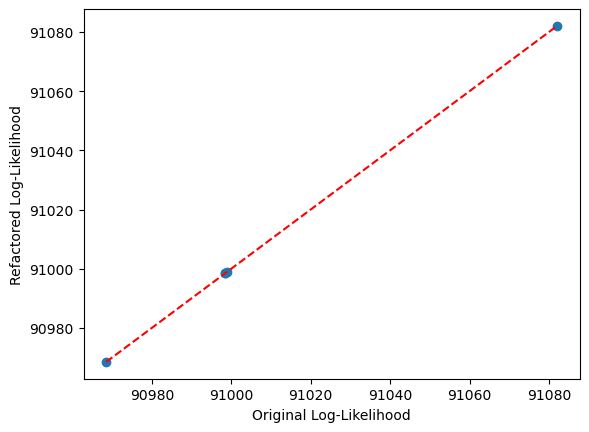

In [35]:
plt.scatter(lls_old, lls_new)
plt.plot([min(lls_old), max(lls_old)], [min(lls_old), max(lls_old)], color='red', linestyle='--')
plt.xlabel('Original Log-Likelihood')
plt.ylabel('Refactored Log-Likelihood')
plt.show()

In [36]:
# Add this to a notebook cell to debug the varP case
import jax

# Create both kernels
m_orig = ds.PulsarLikelihood([psr.residuals, ds.makenoise_measurement_simple(psr)])
m_refact = dsl.PulsarLikelihood([psr.residuals, ds.makenoise_measurement_simple(psr)])

# Explore the structure to find the kernel
print("Original m_orig attributes:", dir(m_orig))
print("Refactored m_refact attributes:", dir(m_refact))

# Try to find the kernel in the likelihood components
print("\nOriginal likelihood components:", m_orig.components)
print("Refactored likelihood components:", m_refact.components)

# Look at the first component that might be the kernel
if hasattr(m_orig.components[0], 'kernel'):
    print("Original kernel type:", type(m_orig.components[0].kernel))
    print("Refactored kernel type:", type(m_refact.components[0].kernel))
else:
    # The kernel might be the component itself
    print("Original component type:", type(m_orig.components[0]))
    print("Refactored component type:", type(m_refact.components[0]))

# Test parameters
test_pars = ds.sample_uniform(m_orig.logL.params)
print("Test parameters:", test_pars)

Original m_orig attributes: ['N', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'clogL', 'conditional', 'delay', 'logL', 'sample', 'sample_conditional', 'y']
Refactored m_refact attributes: ['N', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', 'clogL', 'conditional', 'delay', 'logL', '

AttributeError: 'PulsarLikelihood' object has no attribute 'components'

In [37]:
from jax import make_jaxpr

In [38]:
make_jaxpr(jlogl_m2)(test_pars)

{ lambda ; a:f64[] b:f64[]. let
    c:f64[] = jit[
      name=kernelproduct
      jaxpr={ lambda d:f64[60] e:f64[60] f:f64[60,60] g:f64[] h:f64[60] i:f64[]; a:f64[]
          b:f64[]. let
          j:f64[] = mul 2.0:f64[] b
          k:f64[] = pow 10.0:f64[] j
          l:f64[] = div k 12.0:f64[]
          m:f64[] = div l 9.869604401089358:f64[]
          n:f64[] = sub a 3.0:f64[]
          o:f64[] = pow 3.168808781402895e-08:f64[] n
          p:f64[] = mul m o
          q:f64[] = neg a
          r:f64[] = convert_element_type[new_dtype=float64 weak_type=False] q
          s:f64[60] = pow d r
          t:f64[] = convert_element_type[new_dtype=float64 weak_type=False] p
          u:f64[60] = mul t s
          v:f64[60] = mul u e
          w:f64[60] = div 1.0:f64[] v
          x:f64[60,60] = jit[
            name=_diag
            jaxpr={ lambda ; w:f64[60]. let
                y:f64[60] = pad[padding_config=((0, 0, 0),)] w 0.0:f64[]
                z:i64[60,60] = iota[
                 

In [39]:
make_jaxpr(jlogl_m)(test_pars)

{ lambda ; a:f64[] b:f64[]. let
    c:f64[] = jit[
      name=kernelproduct
      jaxpr={ lambda d:f64[60] e:f64[60] f:f64[60,60] g:f64[60] h:f64[] i:f64[]; a:f64[]
          b:f64[]. let
          j:f64[] = mul 2.0:f64[] b
          k:f64[] = pow 10.0:f64[] j
          l:f64[] = div k 12.0:f64[]
          m:f64[] = div l 9.869604401089358:f64[]
          n:f64[] = sub a 3.0:f64[]
          o:f64[] = pow 3.168808781402895e-08:f64[] n
          p:f64[] = mul m o
          q:f64[] = neg a
          r:f64[] = convert_element_type[new_dtype=float64 weak_type=False] q
          s:f64[60] = pow d r
          t:f64[] = convert_element_type[new_dtype=float64 weak_type=False] p
          u:f64[60] = mul t s
          v:f64[60] = mul u e
          w:f64[60] = div 1.0:f64[] v
          x:f64[60,60] = jit[
            name=_diag
            jaxpr={ lambda ; w:f64[60]. let
                y:f64[60] = pad[padding_config=((0, 0, 0),)] w 0.0:f64[]
                z:i64[60,60] = iota[
                 

In [64]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise'),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, fourierbasis=ds.dmfourierbasis_alpha, name='chromatic'),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, fourierbasis=ds.dmfourierbasis, name='dmgp')
                         ])
m2 = dsl.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise'),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, fourierbasis=ds.dmfourierbasis_alpha, name='chromatic'),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, fourierbasis=ds.dmfourierbasis, name='dmgp')
                         ])

In [65]:
ds.priordict_standard
pdict = {**ds.priordict_standard, **{'(.*_)?chromatic_gamma': [0, 7], '(.*_)?chromatic_log10_A': [-20, -11], '(.*_)?chromatic_alpha': [2, 5] }}

In [66]:
test_pars = ds.sample_uniform(m.logL.params, pdict)

In [67]:
m.logL(test_pars)

Array(90110.0496402, dtype=float64)

In [68]:
print(m2.N.F)

<function CompoundGP.<locals>.F at 0x4b66eab60>


In [74]:
jm = jax.jit(m.logL)
jm(test_pars)
jm2 = jax.jit(m2.logL)
jm2(test_pars)

Array(90110.0496402, dtype=float64)

In [75]:
%%timeit
jax.block_until_ready(jm(test_pars))

32.4 ms ± 274 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
%%timeit
jax.block_until_ready(jm2(test_pars))

31.4 ms ± 280 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
